# Compare predictions of a given image between the 6 models

In [31]:
%load_ext autoreload
%autoreload 2

import os, json, random, torch
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchsummary import summary
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

from utils import image
from utils.data import NumpyImageLoader
from utils.learning import get_best_checkpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
pools = Pool(processes=cpu_count())

/media/antiaegis/storing/datasets/CASIA2/Au/Au_ani_30653.jpg


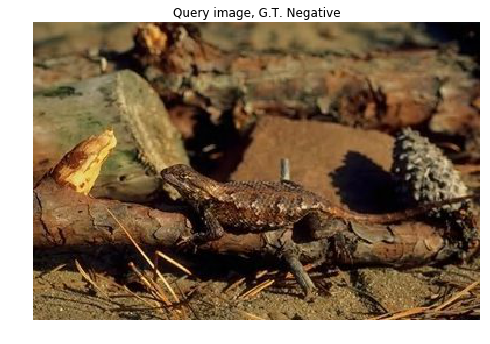

In [33]:
# Query image

files = glob("/media/antiaegis/storing/datasets/CASIA2/**/*.*")
n_files = len(files)
random_idx = random.choice(list(range(n_files)))
IMAGE_FILE = files[random_idx]
print(IMAGE_FILE)

GT = IMAGE_FILE.split("/")[-1][:2]
GT = "Positive" if GT=="Tp" else "Negative"

img_PIL = Image.open(IMAGE_FILE).convert("RGB")
plt.figure(figsize=(8,8))
plt.imshow(img_PIL)
plt.title("Query image, G.T. %s" % (GT))
plt.axis('off')
plt.show()

# 1.MBN2-YCbCr

In [34]:
from utils.MobileNetV2_pretrained_imagenet import MobileNetV2

params = {}
params["channel"] = "YCbCr"
params["threshold"] = 0.65
params["training_log_dir"] = "backup/MBN2-YCbCr/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_class=2, input_size=64, width_mult=1.0).to(device=DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Negative ==> True


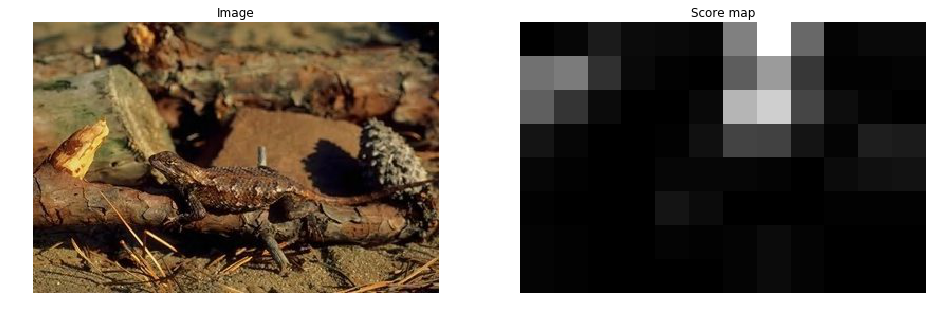

In [35]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()

# 2.MBN2-RGB

In [36]:
from utils.MobileNetV2_pretrained_imagenet import MobileNetV2

params = {}
params["channel"] = "RGB"
params["threshold"] = 0.500
params["training_log_dir"] = "backup/MBN2-RGB/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_class=2, input_size=64, width_mult=1.0).to(device=DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Positive ==> False


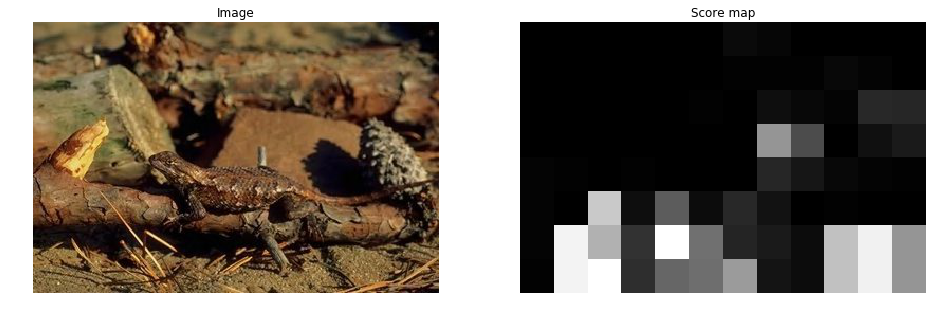

In [37]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()

# 3.MBN2-pre-YCbCr

In [38]:
from utils.MobileNetV2_pretrained_imagenet import MobileNetV2

params["channel"] = "YCbCr"
params["threshold"] = 0.80
params["training_log_dir"] = "backup/MBN2-pre-YCbCr/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_class=2, input_size=64, width_mult=1.0).to(DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Negative ==> True


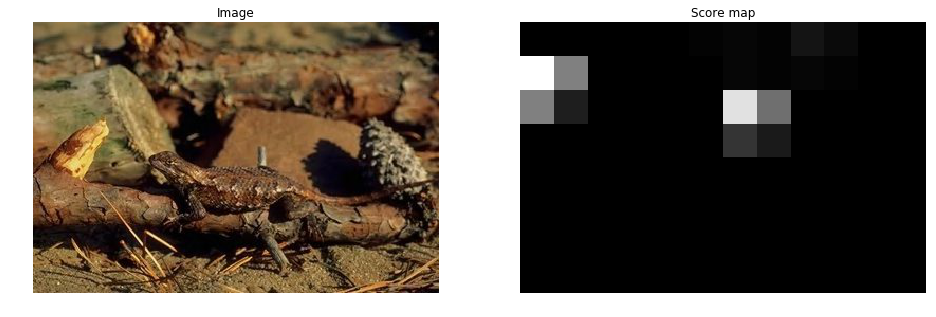

In [39]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()

# 4.MBN2-pre-RGB

In [40]:
from utils.MobileNetV2_pretrained_imagenet import MobileNetV2

params["channel"] = "RGB"
params["threshold"] = 0.80
params["training_log_dir"] = "backup/MBN2-pre-RGB/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_class=2, input_size=64, width_mult=1.0).to(DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Negative ==> True


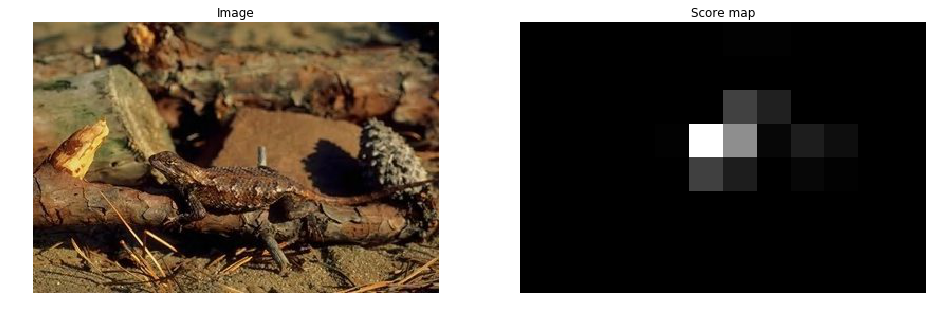

In [41]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()

# 5.MBN2-mod-YCbCr

In [42]:
from utils.models import MobileNetV2

params["channel"] = "YCbCr"
params["threshold"] = 0.645
params["training_log_dir"] = "backup/MBN2-mod-YCbCr/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_classes=2).to(device=DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Negative ==> True


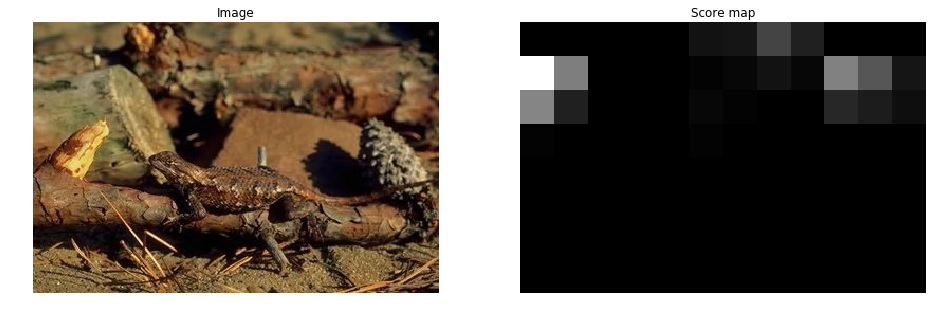

In [43]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()

# 6.MBN2-mod-RGB

In [44]:
from utils.models import MobileNetV2

params["channel"] = "RGB"
params["threshold"] = 0.802
params["training_log_dir"] = "backup/MBN2-mod-RGB/checkpoints/"

MODEL_FILE = os.path.join(params["training_log_dir"], "model.ckpt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV2(n_classes=2).to(device=DEVICE)
model.load(model_file=MODEL_FILE)

Prediction: Negative ==> True


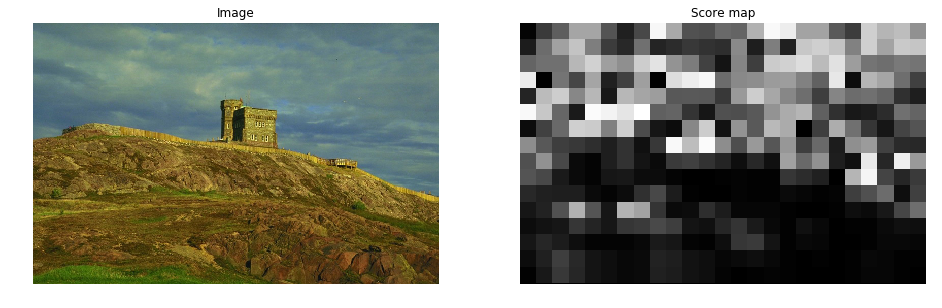

In [30]:
# Load data
img = np.array(Image.open(IMAGE_FILE).convert(params["channel"]))
coords, _, _ = image.slide2d(sz=img.shape[:2], K=64, S=32)
patches = image.crop_patches( img=img, coords=coords, patch_sz=64)
loader = NumpyImageLoader(ndarray_data=patches, batch_size=16, n_workers=cpu_count(), pin_memory=True, shuffle=False).loader

# Predict
softmaxs = []
model.eval()
for X in loader:
    X = X[0].to(DEVICE)
    logits = model(X)
    softmaxs.append(F.softmax(logits, dim=1).detach().cpu().numpy())
softmaxs = np.concatenate(softmaxs, axis=0)

# Post-processing
labels = image.post_process(softmaxs[:,1], coords, 8, params["threshold"], 32, pools=pools)
decision = image.fusion(labels)
if decision==1:
    if GT=="Positive":
        print("Prediction: Positive ==> True")
    else:
        print("Prediction: Positive ==> False")
else:
    if GT=="Positive":
        print("Prediction: Negative ==> False")
    else:
        print("Prediction: Negative ==> True")

# Draw score_map
score_map = image.reconstruct_heatmap(softmaxs[:,1], coords, img.shape, 64)
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img_PIL)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.title("Score map")
plt.axis('off')
plt.show()